In [14]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from IPython.display import Image
from IPython.display import display
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

%matplotlib inline


File count:  23705


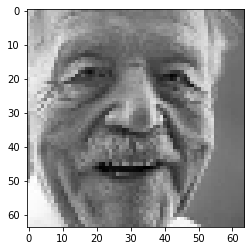

In [2]:
def imshow(img):
    plt.imshow(img, interpolation='bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()


dir_ = 'data/Faces'
count = 0
for path in os.listdir(dir_):
    if os.path.isfile(os.path.join(dir_, path)):
        count += 1
print('File count: ', count)

# get all file names
onlyfiles = os.listdir(dir_)
# reoder the only files based on value
onlyfiles = sorted(onlyfiles, key=lambda x: int(x[:-4]))

X_data = []
for file in onlyfiles:
    face = cv2.imread(dir_+'/' + file)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    face = cv2.resize(face, (64, 64))
    # face = cv2.resize(face, (200, 200))
    X_data.append(face)
X_data = np.array(X_data)
X_data.shape

X = np.squeeze(X_data)
plt.imshow(X[0], cmap="gray")


## Prepare train and test set

In [4]:
path_data = "labels_with_age_group.csv"
data = pd.read_csv(path_data)

encoder = LabelEncoder()
encoder.fit(data["age_group"].unique())
Y = encoder.transform(data["age_group"])

In [114]:
X = X_data
X.resize((23705,1, 64, 64))
X.shape

(23705, 1, 64, 64)

In [115]:


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
X_val = torch.tensor(X_val, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long).squeeze()
y_test = torch.tensor(y_test, dtype=torch.long).squeeze()
y_val = torch.tensor(y_val, dtype=torch.long).squeeze()

In [116]:
np.unique(Y)

array([0, 1, 2, 3, 4, 5])

## Setup loader

In [117]:
BATCH_SIZE = 50


# set up a loader for training and test data
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

val_dataset = Data.TensorDataset(X_val, y_val)
val_loader = Data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False)

test_dataset = Data.TensorDataset(X_test, y_test)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False)


## Architecture Design -- CNN

In [73]:
class netWork(torch.nn.Module):
    def __init__(self):
        super(netWork, self).__init__()

        self.cnn_layers = torch.nn.Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(1, 32, kernel_size=(3,3)),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=(2,2)),
            
            # Defining a 2D convolution layer
            torch.nn.Conv2d(32, 64, kernel_size=(3,3)),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=(2,2)),

            # Defining another 2D convolution layer
            torch.nn.Conv2d(64, 128, kernel_size=(3,3)),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=(2,2)),
            torch.nn.Dropout(p = 0.5, inplace = True)

        )

        self.linear_layers = torch.nn.Sequential(
            torch.nn.Linear(4608, 6)
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x



learning_rate = 0.001
    
model = netWork()     # define the network
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

## Early stopping

In [51]:
# from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.bestModel = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics, curmodel):
        if self.best is None:
            self.best = metrics
            self.bestModel = curmodel
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
            self.bestModel = curmodel
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)
                

                
# play around with patience
# The early stopping module takes in the following parameters
# mode='min' / 'max' - whether smaller or lager is better
# min_delta=0 - a delta that can be used to make early stopping more or less lenient when evaulating "bad" epochs
# patience=10 - how many "bad" epochs that are allowed(epoches with worse score than the current best)
# percentage=False / True - whether the criterion is in percentage or not
earlyStopping = EarlyStopping(patience=5)

Exited due to early stopping


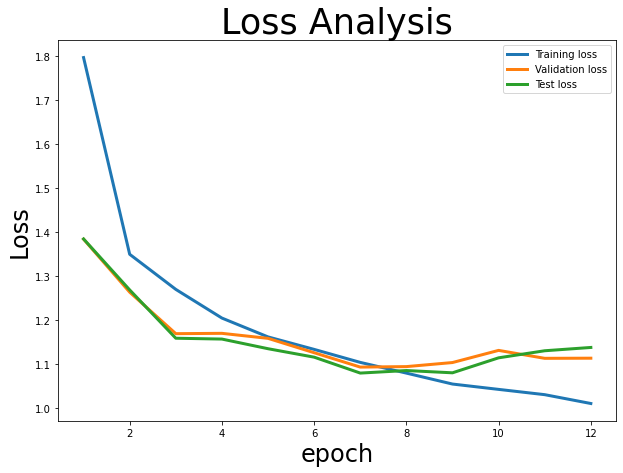

In [52]:
EPOCH = 50
fig, ax = plt.subplots(figsize=(10,7))

# train the network
train_loss_graph = []
val_loss_graph = []
test_loss_graph = []
for epoch in range(EPOCH):
    train_loss_tot = 0 # Save for plotting
    model.train() # prepare model for training
    for s, (inputs_, targets_) in enumerate(train_loader): # for each training step
        
        predictions = model(inputs_)     # input x and predict based on x
        
        loss = loss_func(predictions, targets_)   # compute the loss. must be (1. nn output, 2. target)
        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients 

        #save the loss for plotting
        train_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    val_loss_tot = 0 # Save for plotting
    model.eval() # prepare model for testing
    for s, (inputs_, targets_) in enumerate(val_loader): # for each testing batch
                
        predictions = model(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        val_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    test_loss_tot = 0 # Save for plotting
    for s, (inputs_, targets_) in enumerate(test_loader): # for each testing batch
                
        predictions = model(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        test_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
        
    train_loss_graph.append(train_loss_tot/len(train_dataset))
    val_loss_graph.append(val_loss_tot/len(val_dataset))
    test_loss_graph.append(test_loss_tot/len(test_dataset))

    plt.cla()
    # plot and show learning process
    ax.set_title('Loss Analysis', fontsize=35)
    ax.set_xlabel('epoch', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)
    x = np.arange(1,epoch+2)
    
    ax.plot(x, train_loss_graph, lw=3, label='Training loss')
    ax.plot(x, val_loss_graph, lw=3, label='Validation loss')
    ax.plot(x, test_loss_graph, lw=3, label='Test loss')
    ax.legend()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    
    if earlyStopping.step(torch.tensor(val_loss_tot/len(val_dataset)),model):
        print('Exited due to early stopping')
        model = earlyStopping.bestModel
        break  # early stop criterion is met, we can stop now

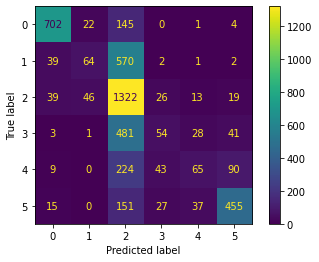

In [53]:
preds_tot = torch.zeros(len(test_dataset),6)
for s, (inputs_, _) in enumerate(test_loader): # for each testing batch
                
    predictions = model(inputs_)     # input x and predict based on x
    
    endIndex = (BATCH_SIZE*(s+1)) if (BATCH_SIZE*(s+1)) <= len(test_dataset) else len(test_dataset)
    preds_tot[(BATCH_SIZE*s):endIndex,:] = predictions.data
    
preds = np.argmax(preds_tot,axis=1)
cm = confusion_matrix(y_test,preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [54]:
accuracy_score(y_test, preds)

0.5614849187935035

In [61]:
torch.save(model.state_dict(), "CNN_parameter")


## Architecture Design -- ANN

In [118]:
# ann with 2 layers
class netWork(torch.nn.Module):
    def __init__(self, n_feature, n_hidden_layer, n_output):
        super(netWork, self).__init__()

        # Linear function 1: 784 --> 150
        self.fc1 = torch.nn.Linear(n_feature, n_hidden_layer)
        # Non-linearity 1
        self.relu1 = torch.nn.ReLU()
         
        # Linear function 2: 150 --> 150
        self.fc2 = torch.nn.Linear(n_hidden_layer, n_hidden_layer)
        # Non-linearity 2
        self.tanh2 = torch.nn.Tanh()
         
        # Linear function 3: 150 --> 150
        self.fc3 = torch.nn.Linear(n_hidden_layer, n_hidden_layer)
        # Non-linearity 3
        self.elu3 = torch.nn.ELU()
         
        # Linear function 4 (readout): 150 --> 10
        self.fc4 = torch.nn.Linear(n_hidden_layer, n_output) 
     
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
         
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
         
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
         
        # Linear function 4 (readout)
        out = self.fc4(out)

        print(out)
        return out

num_classes= 6
number_of_features = 64
n_hidden_layers = 128
learning_rate = 0.001
    
model = netWork(n_feature=number_of_features, n_hidden_layer = n_hidden_layers, n_output=num_classes)     # define the network
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

tensor([[[[ 0.2253,  0.2822, -0.2234, -0.0078, -0.0050, -0.1870],
          [ 0.1806,  0.2827, -0.0634, -0.0305,  0.0241, -0.1514],
          [ 0.3113,  0.1571,  0.1149, -0.0893,  0.0527, -0.3280],
          ...,
          [ 0.2710,  0.2180,  0.2047,  0.1204, -0.0625, -0.0162],
          [ 0.2700,  0.0797,  0.1647,  0.0559, -0.0723, -0.0039],
          [ 0.2846,  0.1411,  0.1924,  0.1050, -0.0695, -0.0573]]],


        [[[ 0.2012, -0.1029,  0.4046, -0.0350,  0.0682, -0.1569],
          [ 0.1996, -0.0783,  0.4173, -0.0431,  0.0936, -0.2207],
          [ 0.1843, -0.0602,  0.4098, -0.0205,  0.0984, -0.2195],
          ...,
          [ 0.1587,  0.1991,  0.0900,  0.2305, -0.3088, -0.3253],
          [ 0.0748, -0.0261,  0.2183, -0.0209, -0.2129, -0.5182],
          [ 0.0862, -0.1335,  0.1574, -0.0102, -0.2124, -0.5212]]],


        [[[ 0.0336, -0.1784,  0.3309, -0.0064, -0.0315,  0.0837],
          [ 0.1234, -0.1370,  0.3126, -0.0198,  0.0431,  0.0511],
          [ 0.1013, -0.0342,  0.3812, 

RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1

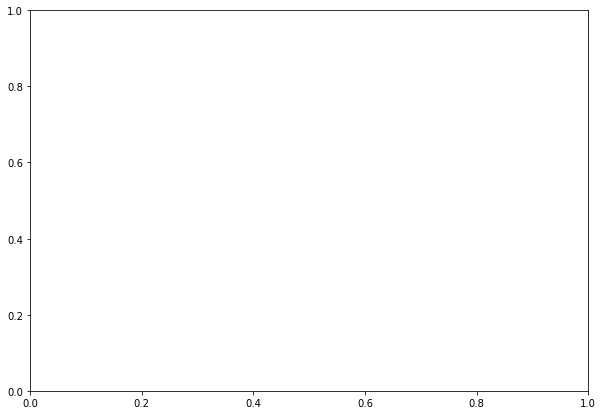

In [119]:
EPOCH = 500
fig, ax = plt.subplots(figsize=(10,7))

# train the network
train_loss_graph = []
val_loss_graph = []
test_loss_graph = []
for epoch in range(EPOCH):
    train_loss_tot = 0 # Save for plotting
    model.train() # prepare model for training
    for s, (inputs_, targets_) in enumerate(train_loader): # for each training step
        
        predictions = model(inputs_)     # input x and predict based on x
        print(predictions)
        loss = loss_func(predictions, targets_)   # compute the loss. must be (1. nn output, 2. target)
        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients 

        #save the loss for plotting
        train_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    val_loss_tot = 0 # Save for plotting
    model.eval() # prepare model for testing
    for s, (inputs_, targets_) in enumerate(val_loader): # for each testing batch
                
        predictions = model(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        val_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    test_loss_tot = 0 # Save for plotting
    for s, (inputs_, targets_) in enumerate(test_loader): # for each testing batch
                
        predictions = model(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        test_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
        
    train_loss_graph.append(train_loss_tot/len(train_dataset))
    val_loss_graph.append(val_loss_tot/len(val_dataset))
    test_loss_graph.append(test_loss_tot/len(test_dataset))

    plt.cla()
    # plot and show learning process
    ax.set_title('Loss Analysis', fontsize=35)
    ax.set_xlabel('epoch', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)
    x = np.arange(1,epoch+2)
    
    ax.plot(x, train_loss_graph, lw=3, label='Training loss')
    ax.plot(x, val_loss_graph, lw=3, label='Validation loss')
    ax.plot(x, test_loss_graph, lw=3, label='Test loss')
    ax.legend()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    
    if earlyStopping.step(torch.tensor(val_loss_tot/len(val_dataset)),model):
        print('Exited due to early stopping')
        model = earlyStopping.bestModel
        break  # early stop criterion is met, we can stop now